# Level2. BoWにTF-IDFで重み調整した特徴ベクトルを生成する

In [1]:
import numpy as np
import pandas as pd
import re
import nltk
import scipy.spatial.distance as distance
import sklearn.feature_extraction.text as fe_text

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Hiragino Maru Gothic Pro', 'Yu Gothic', 'Meirio', 'Takao', 'IPAexGothic', 'IPAPGothic', 'VL PGothic', 'Noto Sans CJK JP']

from nltk.tokenize import wordpunct_tokenize, sent_tokenize
# nltk.download('stopwords')

/usr/local/var/pyenv/versions/3.7.4/lib/python3.7/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
/usr/local/var/pyenv/versions/3.7.4/lib/python3.7/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


## データの読み込み

In [2]:
docs = {}
for idx in range(13):
    with open(f'../dataset/ch{idx:02}.html') as f:
        docs[f'ch{idx:02}'] = f.read()

In [3]:
print(docs['ch00'][:300])

<?xml version="1.0" encoding="ascii" ?>

<script language="javascript" type="text/javascript">

function astext(node)
{
    return node.innerHTML.replace(/(<([^>]+)>)/ig,"")
                         .replace(/&gt;/ig, ">")
                         .replace(/&lt;/ig, "<")
                         .re


### 前処理をかける

In [4]:
def preprocessing(raw_text):
    bodytext = re.findall(r'<body>.+</body>', raw_text.replace('\n', ' '))[0]
    body_text_removed_HTMLTag = re.sub('<[^>]+>', '', bodytext)
#     sentence_list = body_text_removed_HTMLTag.split('. ') # ピリオドも削除されてしまうが、ストップワードで消えるので問題ない
    return body_text_removed_HTMLTag

In [5]:
for k, d in docs.items():
    docs[k] = preprocessing(d)

In [6]:
print(docs['ch00'][:300])

  Preface                                    This is a book about Natural Language Processing. By &quot;natural language&quot; we mean a language that is used for everyday communication by humans; languages like English, Hindi or Portuguese. In contrast to artificial languages such as programming la


## BoWをsklearnのライブラリで計算する
ベクトルの次元数が合わなかったので色々調整した

https://qiita.com/asatohan/items/7a247eb533a5adba9e87

原因
- stopwordsが設定されていなかった
- tokenizerが設定されていなかった
- analyzerがwordに設定されていなければstopwordもtokenizerも効かないので設定する必要があった

In [7]:
stopwords = nltk.corpus.stopwords.words('english')
stopwords.append('.')   # ピリオドを追加。
stopwords.append(',')   # カンマを追加。
stopwords.append('')

In [8]:
def tokenizer(doc):
    token = []
    wnl = nltk.stem.wordnet.WordNetLemmatizer()
    for sent in sent_tokenize(doc):
        for word in wordpunct_tokenize(sent):
            this_word = wnl.lemmatize(word.lower())
            token.append(this_word)
    return token

In [9]:
def bow(docs, stopwords, tokenizer):
    '''Bag-of-Wordsによるベクトルを生成。

    :param docs(list): 1文書1文字列で保存。複数文書をリストとして並べたもの。
    :return: 文書ベクトル。
    '''
    vectorizer = fe_text.CountVectorizer(stop_words=stopwords,
                                         tokenizer=tokenizer,
                                         analyzer="word")
    vectors = vectorizer.fit_transform(docs)
    return vectors.toarray(), vectorizer

In [10]:
vectors, vectorizer = bow(list(docs.values()), stopwords, tokenizer)
print('# normal BoW')
# print(vectorizer.get_feature_names())
print(vectors)
print(vectors.shape)

/usr/local/var/pyenv/versions/3.7.4/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'", 'doe', 'ha', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


# normal BoW
[[1 0 0 ... 0 0 0]
 [8 0 1 ... 0 0 0]
 [3 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [3 0 0 ... 0 0 1]
 [1 0 0 ... 0 0 0]]
(13, 10449)


次元数がLevel1と一致した。

## BoW + TFidf

In [11]:
def bow_tfidf(docs, stopwords, tokenizer):
    '''Bag-of-WordsにTF-IDFで重み調整したベクトルを生成。

    :param docs(list): 1文書1文字列で保存。複数文書をリストとして並べたもの。
    :return: 重み調整したベクトル。
    '''
    vectorizer = fe_text.TfidfVectorizer(norm=None,
                                         stop_words=stopwords,
                                         tokenizer=tokenizer,
                                         analyzer="word")
    vectors = vectorizer.fit_transform(docs)
    return vectors.toarray(), vectorizer

In [12]:
tf_vectors, tf_vectorizer = bow_tfidf(list(docs.values()), stopwords, tokenizer)
print('# BoW + tfidf')
# print(vectorizer.get_feature_names())
print(tf_vectors)
print(tf_vectors.shape)

# BoW + tfidf
[[1.24116206 0.         0.         ... 0.         0.         0.        ]
 [9.92929645 0.         2.54044504 ... 0.         0.         0.        ]
 [3.72348617 0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [3.72348617 0.         0.         ... 0.         0.         2.94591015]
 [1.24116206 0.         0.         ... 0.         0.         0.        ]]
(13, 10449)


## Cosine similarity

In [13]:
def cosine_similarity(vectors):
    vectors = np.array(vectors)
    distances = []
    for i in range(len(vectors)):
        temp = []
        for j in range(len(vectors)):
            temp.append(1 - distance.cosine(vectors[i], vectors[j]))
        distances.append(temp)
    return distances

In [14]:
cos_similarity_matrix = np.array(cosine_similarity(vectors)).astype(float)
tf_cos_similarity_matrix = np.array(cosine_similarity(tf_vectors)).astype(float)

In [15]:
print(cos_similarity_matrix)

[[1.         0.41096018 0.32572154 0.37307515 0.41432588 0.37788894
  0.41175418 0.45486605 0.47101329 0.31412722 0.34754576 0.42305562
  0.75351216]
 [0.41096018 1.         0.89881764 0.95918683 0.95186228 0.91432704
  0.79471295 0.76542878 0.76283245 0.68038865 0.77147264 0.84982529
  0.41589973]
 [0.32572154 0.89881764 1.         0.93557596 0.86924666 0.90720589
  0.65443203 0.64404071 0.64047224 0.6311044  0.60827352 0.6956173
  0.31476542]
 [0.37307515 0.95918683 0.93557596 1.         0.93941615 0.91874043
  0.75514858 0.75520551 0.74716619 0.70535771 0.73466085 0.82278047
  0.38027122]
 [0.41432588 0.95186228 0.86924666 0.93941615 1.         0.90196483
  0.82118901 0.79743713 0.7945122  0.74817703 0.8019962  0.8409703
  0.40732625]
 [0.37788894 0.91432704 0.90720589 0.91874043 0.90196483 1.
  0.76311029 0.79180083 0.73509403 0.67859625 0.71838142 0.7826605
  0.38393269]
 [0.41175418 0.79471295 0.65443203 0.75514858 0.82118901 0.76311029
  1.         0.79117665 0.77917269 0.698237

In [16]:
print(tf_cos_similarity_matrix)

[[1.         0.35827094 0.27603964 0.32360092 0.36370106 0.31985933
  0.3456006  0.37662436 0.38407181 0.23806472 0.2907469  0.36328169
  0.61482342]
 [0.35827094 1.         0.872059   0.93774057 0.92682491 0.86969079
  0.716641   0.6920962  0.67226171 0.5679493  0.70740055 0.79746457
  0.33638565]
 [0.27603964 0.872059   1.         0.90911872 0.83954857 0.86216289
  0.58486239 0.57739334 0.55427073 0.5199608  0.54991291 0.65057611
  0.24862051]
 [0.32360092 0.93774057 0.90911872 1.         0.91679791 0.87765126
  0.6840216  0.6867168  0.66113365 0.59350903 0.6769611  0.7775439
  0.30648845]
 [0.36370106 0.92682491 0.83954857 0.91679791 1.         0.85791997
  0.74416219 0.7234484  0.70512917 0.636331   0.7386024  0.7932349
  0.32952439]
 [0.31985933 0.86969079 0.86216289 0.87765126 0.85791997 1.
  0.68190769 0.73245787 0.63864896 0.56351151 0.64521445 0.72106376
  0.30243992]
 [0.3456006  0.716641   0.58486239 0.6840216  0.74416219 0.68190769
  1.         0.68591886 0.65204014 0.56164

tf_idfで重み付けした場合の類似度は、bow単体の類似度より低くなってるなー。  
やっぱり文書中に多く出現している単語（記号）に引っ張られて類似度が上がってたんだろうな...

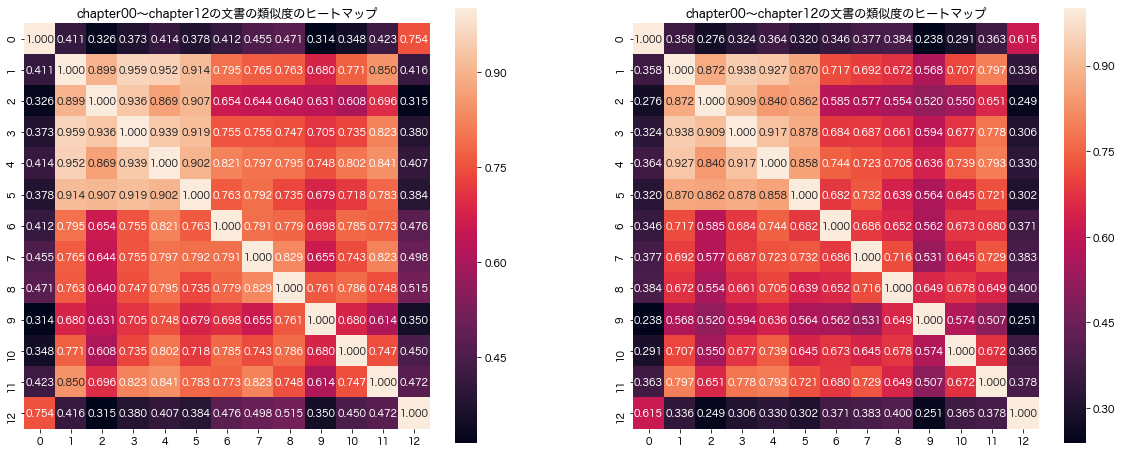

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(20,8))
sns.heatmap(cos_similarity_matrix, annot=True, fmt='.3f', square=True, ax=ax[0])
ax[0].set_ylim(13, 0)
ax[0].set_title("chapter00〜chapter12の文書の類似度のヒートマップ")
sns.heatmap(tf_cos_similarity_matrix, annot=True, fmt='.3f', square=True, ax=ax[1])
ax[1].set_ylim(13, 0)
ax[1].set_title("chapter00〜chapter12の文書の類似度のヒートマップ")
plt.show()

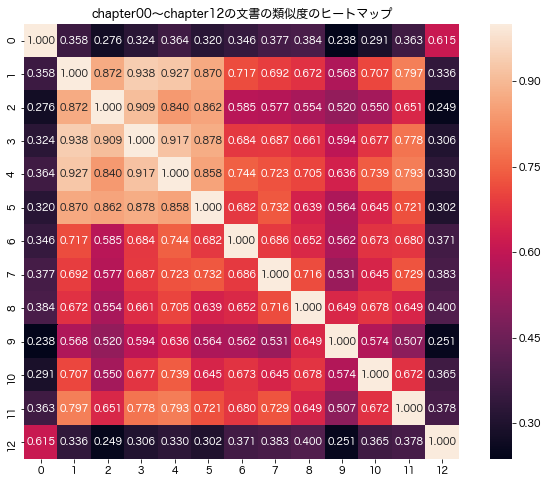

In [18]:
fig, ax = plt.subplots(figsize=(11,8))
sns.heatmap(tf_cos_similarity_matrix, annot=True, fmt='.3f', square=True, ax=ax)
ax.set_ylim(13, 0)
plt.title("chapter00〜chapter12の文書の類似度のヒートマップ")
plt.show()

chapter1とchapter３の類似度がもっとも高い...  
類似度が高くなった理由はなんだろう...

## chapter1とchapter3の類似度が高い理由を考える

In [19]:
len(tf_vectorizer.get_feature_names())

10449

In [20]:
df = pd.DataFrame(columns=vectorizer.get_feature_names(), data=np.array(vectors)).T
df

,0,1,2,3,4,5,6,7,8,9,10,11,12
!,1,8,3,9,8,5,0,0,4,1,0,3,1
!&,0,0,0,2,0,0,0,0,0,0,0,0,0
!',0,1,0,0,0,1,0,0,0,0,0,0,0
!),0,1,0,1,0,0,0,0,0,0,0,0,0
"!,",0,0,0,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
"}],",0,0,0,0,2,0,0,0,0,0,0,0,0
}]],0,0,0,0,1,0,0,0,0,0,0,0,0
}}',0,0,0,1,0,0,0,0,0,0,0,0,0
}}'.,0,0,0,3,0,0,0,0,0,0,0,0,0


In [21]:
columns = []
data = []
for idx, d in df.iterrows():
    if sum(d.values) > 400:
        columns.append(idx)
        data.append(d)

In [22]:
vector2 = np.array(data).T

In [23]:
df2 = pd.DataFrame(data=data)
df2.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
&,16,413,427,707,531,438,369,406,223,186,498,776,19
&#,23,68,48,135,62,58,39,22,54,45,228,24,10
',18,461,1021,1107,588,627,187,150,230,499,235,209,8
"',",0,384,956,780,379,541,79,74,19,67,71,147,0
(,21,264,273,421,448,318,415,290,343,333,965,188,27


In [24]:
df2['sum'] = df2.apply(lambda x: sum(x), axis=1)

In [25]:
df2 = df2.sort_values('sum', ascending=False).drop('sum', axis=1)
df2.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
gt,3,593,685,989,816,682,399,281,258,411,813,617,0
;,57,532,486,902,616,535,448,390,404,451,819,735,35
',18,461,1021,1107,588,627,187,150,230,499,235,209,8
&,16,413,427,707,531,438,369,406,223,186,498,776,19
;&,2,444,518,697,567,523,336,241,176,174,496,357,0


In [26]:
df3 = df２.apply(lambda x: x/sum(x))
df3.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
gt,0.004444,0.111445,0.094875,0.109487,0.108873,0.097082,0.081263,0.064390,0.065119,0.077708,0.116593,0.114492,0.000000
;,0.084444,0.099981,0.067313,0.099856,0.082188,0.076157,0.091242,0.089368,0.101969,0.085271,0.117453,0.136389,0.100287
',0.026667,0.086638,0.141413,0.122551,0.078452,0.089253,0.038086,0.034372,0.058051,0.094347,0.033701,0.038783,0.022923
&,0.023704,0.077617,0.059141,0.078269,0.070847,0.062349,0.075153,0.093034,0.056285,0.035167,0.071418,0.143997,0.054441
;&,0.002963,0.083443,0.071745,0.077162,0.075650,0.074448,0.068432,0.055225,0.044422,0.032898,0.071132,0.066246,0.000000


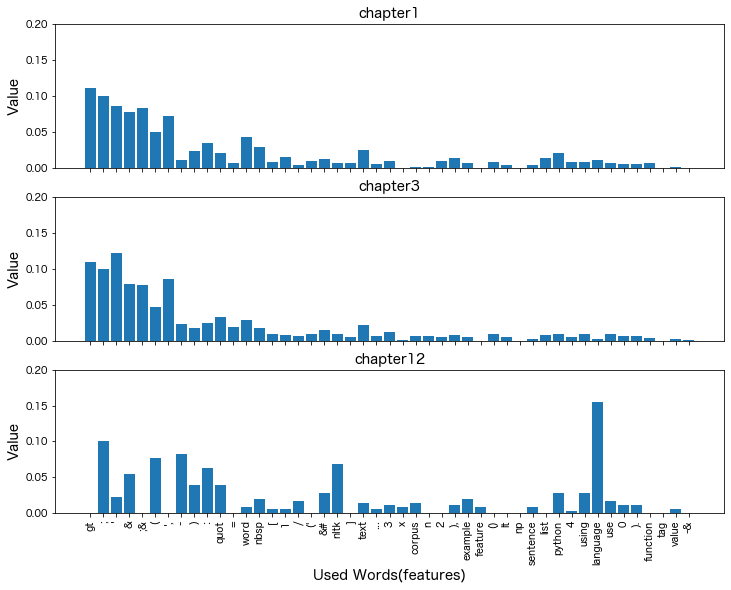

In [27]:
fig, axs = plt.subplots(3, 1, figsize=(12,9))
axs[0].bar(df3.index, df3[1])
axs[0].set_title('chapter1', fontsize=14)
axs[1].bar(df3.index, df3[3])
axs[1].set_title('chapter3', fontsize=14)
axs[2].bar(df3.index, df3[12])
axs[2].set_title('chapter12', fontsize=14)

for ax in axs.flat:
    ax.set_ylim([0, 0.2])
    ax.set_xlabel('Used Words(features)', fontsize=14)
    ax.set_ylabel('Value', fontsize=14)
    
plt.xticks(rotation=90)

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

tf-idfで重みの調整を行っても、あまり単語の分布に関しては変化が見られないな。  
x軸のwordが変わっているな。